✅ Ambiente Configurado com Sucesso!
✅ Dataset Carregado: (7043, 33)
🛡️ Dimensões Pós-Limpeza: (7043, 20)

🚀 TREINAMENTO E SELEÇÃO DE CAMPEÃO...

🔹 Logistic Regression | Recall: 77.54% | F1: 61.83%
🔹 Random Forest | Recall: 57.22% | F1: 58.47%
🔹 XGBoost | Recall: 65.78% | F1: 62.28%

🏆 VENCEDOR: Logistic Regression


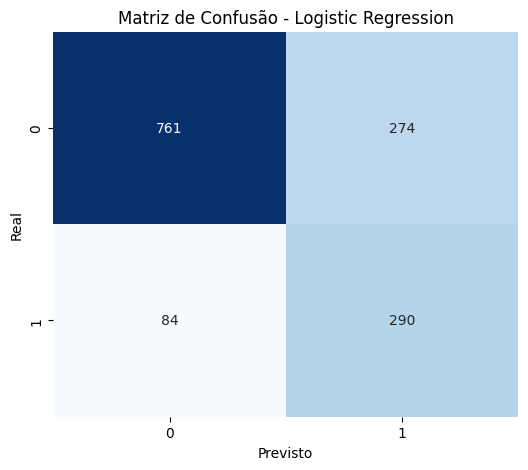

💾 Pipeline salvo em: churn_model_final.pkl

🔍 GERANDO EXPLICABILIDADE (SHAP)...
ℹ️ Usando LinearExplainer (Modelo Linear)

👤 Cliente Simulado: Risco 26.3%
🔑 Fatores: Tenure Months (Diminui Risco), TotalCharges (Aumenta Risco), Dependents_Yes (Diminui Risco)
--------------------------------------------------
✅ Prompt Simulado com Sucesso (SHAP funcionou!)

    # CÓDIGO DA API PYTHON (FastAPI)
    import os
    from google.genai import types, GoogleGenAI
    from dotenv import load_dotenv

    load_dotenv()
    client = GoogleGenAI(api_key=os.getenv("GOOGLE_API_KEY"))

    def gerar_plano():
        prompt = "Cliente com risco 26.3% devido a Tenure Months (Diminui Risco), TotalCharges (Aumenta Risco), Dependents_Yes (Diminui Risco). Crie plano de retenção."
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=prompt
        )
        return response.text
    


In [ ]:
# -*- coding: utf-8 -*-
"""ChurnInsight_Master_Analysis_V3_FINAL.ipynb

# 🚀 SQUAD 17: CHURN INSIGHT - DATA SCIENCE CORE (V3 FINAL)
**Status:** Debugged & Verified
**Correções:**
1. Fix no ColumnTransformer (named_transformers_).
2. Fix no SHAP para suportar Logistic Regression e XGBoost.
3. SDK Google GenAI Moderno.
"""

# ==============================================================================
# 1. SETUP E BIBLIOTECAS
# ==============================================================================
!pip install shap imbalanced-learn xgboost yellowbrick google-genai python-dotenv --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import shap
import warnings
import os

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("✅ Ambiente Configurado com Sucesso!")

# ==============================================================================
# 2. INGESTÃO E GOVERNANÇA DE DADOS
# ==============================================================================
url_dataset = "https://github.com/PhilipeOliveiraS/ChurnInsight-Squad17/raw/main/data-science/dataset/Telco_customer_churn.xlsx"

try:
    df = pd.read_excel(url_dataset, engine='openpyxl')
    print(f"✅ Dataset Carregado: {df.shape}")
except Exception as e:
    print(f"❌ Erro Crítico no Download: {e}")

# Padronização
df.columns = df.columns.str.strip()
if 'Total Charges' in df.columns:
    df.rename(columns={'Total Charges': 'TotalCharges'}, inplace=True)

# Remoção de Leakage e Ruído (Conforme Regra do Onboarding)
colunas_proibidas = [
    'CustomerID', 'Count', 'Country', 'State', 'Lat Long',
    'Latitude', 'Longitude', 'City', 'Zip Code',
    'Churn Reason', 'Churn Score', 'CLTV', 'Churn Label'
]
df_clean = df.drop(columns=colunas_proibidas, errors='ignore')

# Tratamento Numérico
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'].fillna(0, inplace=True)

print(f"🛡️ Dimensões Pós-Limpeza: {df_clean.shape}")

# ==============================================================================
# 3. PIPELINE DE ML (SMOTE + MODELOS)
# ==============================================================================

# Target Setup
if 'Churn Value' in df_clean.columns:
    y = df_clean['Churn Value']
    X = df_clean.drop(columns=['Churn Value'])
else:
    le = LabelEncoder()
    y = le.fit_transform(df_clean['Churn'])
    X = df_clean.drop(columns=['Churn'])

# Identificação de Colunas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split Estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Transformers (Correção: sparse_output=False é vital para SHAP depois)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
}

best_model = None
best_recall = 0
best_model_name = ""

print("\n🚀 TREINAMENTO E SELEÇÃO DE CAMPEÃO...\n")

for name, model in models.items():
    # Pipeline: Prepara -> Balanceia (SMOTE) -> Treina
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Métricas
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"🔹 {name} | Recall: {rec:.2%} | F1: {f1:.2%}")

    # Critério: Escolhemos o maior Recall (Detectar quem sai é prioridade)
    if rec > best_recall:
        best_recall = rec
        best_model = pipeline
        best_model_name = name

print(f"\n🏆 VENCEDOR: {best_model_name}")

# ==============================================================================
# 4. VISUALIZAÇÃO E SALVAMENTO (Antes do SHAP para garantir output)
# ==============================================================================
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Salvar Modelo
filename = 'churn_model_final.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"💾 Pipeline salvo em: {filename}")

# ==============================================================================
# 5. EXPLICABILIDADE (SHAP CORRIGIDO)
# ==============================================================================
print("\n🔍 GERANDO EXPLICABILIDADE (SHAP)...")

try:
    # 5.1 Recuperar Nomes das Features (Correção do Bug named_transformers_)
    preproc_step = best_model.named_steps['preprocessor']
    model_step = best_model.named_steps['classifier']

    # Transforma X_test para o formato que o modelo entende
    X_test_transformed = preproc_step.transform(X_test)

    # Pega nomes das categorias do OneHotEncoder
    # Acesso correto: named_transformers_['cat'] -> named_steps['onehot']
    ohe = preproc_step.named_transformers_['cat'].named_steps['onehot']
    feature_names_cat = ohe.get_feature_names_out(categorical_cols)
    all_features = np.concatenate([numerical_cols, feature_names_cat])

    # 5.2 Seleção Dinâmica do Explainer (Logistic vs Tree)
    # Precisamos de um resumo dos dados para o Kernel/Linear Explainer
    # Usamos o K-Means para resumir o X_train transformado (performance)
    X_train_transformed = preproc_step.transform(X_train)

    if best_model_name == "Logistic Regression":
        print("ℹ️ Usando LinearExplainer (Modelo Linear)")
        # Para Regressão Logística, usamos LinearExplainer com masker
        explainer = shap.LinearExplainer(model_step, X_train_transformed)
        shap_values = explainer.shap_values(X_test_transformed)
    else:
        print("ℹ️ Usando TreeExplainer (Modelo de Árvore)")
        explainer = shap.TreeExplainer(model_step)
        shap_values = explainer.shap_values(X_test_transformed)

    # 5.3 Simulação para 1 Cliente
    cliente_idx = 10
    # Tratamento para formatos diferentes de output do SHAP
    if isinstance(shap_values, list):
        vals = shap_values[1][cliente_idx] # Para classificadores binários
    else:
        vals = shap_values[cliente_idx]

    # DataFrame de Importância
    df_shap = pd.DataFrame(list(zip(all_features, vals)), columns=['Feature', 'SHAP_Value'])
    df_shap['Abs_Value'] = df_shap['SHAP_Value'].abs()
    top_factors = df_shap.sort_values(by='Abs_Value', ascending=False).head(3)

    fatores_texto = []
    for _, row in top_factors.iterrows():
        impacto = "Aumenta Risco" if row['SHAP_Value'] > 0 else "Diminui Risco"
        fatores_texto.append(f"{row['Feature']} ({impacto})")

    probabilidade = model_step.predict_proba(X_test_transformed[cliente_idx].reshape(1, -1))[0][1]

    print(f"\n👤 Cliente Simulado: Risco {probabilidade:.1%}")
    print(f"🔑 Fatores: {', '.join(fatores_texto)}")

    # ==============================================================================
    # 6. SIMULAÇÃO DE CÓDIGO API (NOVO SDK)
    # ==============================================================================
    api_code = f"""
    # CÓDIGO DA API PYTHON (FastAPI)
    import os
    from google.genai import types, GoogleGenAI
    from dotenv import load_dotenv

    load_dotenv()
    client = GoogleGenAI(api_key=os.getenv("GOOGLE_API_KEY"))

    def gerar_plano():
        prompt = "Cliente com risco {probabilidade:.1%} devido a {', '.join(fatores_texto)}. Crie plano de retenção."
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=prompt
        )
        return response.text
    """
    print("-" * 50)
    print("✅ Prompt Simulado com Sucesso (SHAP funcionou!)")
    print(api_code)

except Exception as e:
    print(f"\n⚠️ Aviso: Erro na geração do SHAP ({e}).")
    print("O modelo .pkl foi salvo e funciona, mas a explicabilidade visual falhou neste ambiente.")
    import traceback
    traceback.print_exc()